# NLP Assg 2

Created by: CHIN WEI RU (154717)
Submitted to: Dr. Tan Tien Ping

**Note that this notebook is encouraged to run using GPU for optimal performance.

Kindly change the path of your file before running this program.

#  **Data Loading & Preprocessing**

**Load all datasets (train, test, dev) and convert to lists of strings**

In [207]:
# Load dataset
train_en, train_my, train_cl = open("train.en").read(), open("train.my").read(), open("train.cl").read()
dev_en, dev_my, dev_cl = open("dev.en").read(),open("dev.my").read(),open("dev.cl").read()
test_en, test_my, test_cl = open("test.en").read(),open("test.my").read(),open("test.cl").read()

In [208]:
# Convert strings into list
train_en, train_my, train_cl  = list(train_en.splitlines()),list(train_my.splitlines()),list(train_cl.splitlines())
dev_en, dev_my, dev_cl  = list(dev_en.splitlines()),list(dev_my.splitlines()),list(dev_cl.splitlines())
test_en, test_my, test_cl  = list(test_en.splitlines()),list(test_my.splitlines()),list(test_cl.splitlines())

**Tokenization**

In [209]:
# Import necessary library

import nltk
from nltk.tokenize import TweetTokenizer

In [210]:
# initialize a tokenizer
tokenizer = TweetTokenizer()

In [211]:
# Tokenize strings into lists of tokens for:
# Training Data
train_en_tokens = [tokenizer.tokenize(s) for s in train_en]
train_my_tokens = [tokenizer.tokenize(s) for s in train_my]

# Validation Data
dev_en_tokens = [tokenizer.tokenize(s) for s in dev_en]
dev_my_tokens = [tokenizer.tokenize(s) for s in dev_my]

# Testing Data
test_en_tokens = [tokenizer.tokenize(s) for s in test_en]
test_my_tokens = [tokenizer.tokenize(s) for s in test_my]

In [212]:
from keras.preprocessing.text import Tokenizer

# Initialize the Tokenizer from keras 
# for usage of converting tokens to sequences
tokenizer_k = Tokenizer()

In [213]:
# This section is to convert tokens to sequences to fit in the Siamese NN model later

# Training Data
# Fit the tokenizer on your training data
tokenizer_k.fit_on_texts(train_en_tokens + train_my_tokens)

# Convert the tokens to sequences
train_en_sequences = tokenizer_k.texts_to_sequences(train_en_tokens)
train_my_sequences = tokenizer_k.texts_to_sequences(train_my_tokens)

# Validation Data
dev_en_sequences = tokenizer_k.texts_to_sequences(dev_en_tokens)
dev_my_sequences = tokenizer_k.texts_to_sequences(dev_my_tokens)

# Testing Data
test_en_sequences = tokenizer_k.texts_to_sequences(test_en_tokens)
test_my_sequences = tokenizer_k.texts_to_sequences(test_my_tokens)

In [214]:
# Get the maximum length of total of train_en and train_my sequences
max_length = max(map(len, train_en_sequences + train_my_sequences))
print(max_length)

548


**Padding the sequences**

In [215]:
from keras_preprocessing.sequence import pad_sequences

#  Pad the sequence to make them having the same length
# Training Data
train_en_sequences = pad_sequences(train_en_sequences, maxlen=max_length)
train_my_sequences = pad_sequences(train_my_sequences, maxlen=max_length)

# Validation Data
dev_en_sequences = pad_sequences(dev_en_sequences, maxlen=max_length)
dev_my_sequences = pad_sequences(dev_my_sequences, maxlen=max_length)

# Testing Data
test_en_sequences = pad_sequences(test_en_sequences, maxlen=max_length)
test_my_sequences = pad_sequences(test_my_sequences, maxlen=max_length)

In [216]:
# Combine two languages tokens
vocab_tokens = train_en_tokens + train_my_tokens

# Get the vocab size for the combined lists to fit in NN model
vocab_size = len(set(str(x) for x in vocab_tokens))
print(vocab_size)

180824


# **Word Embedding**

**Word2Vec model is created to train the english and malay tokens.**
In this case, skip-gram is used by specifying sg=1.

In [259]:
from gensim.models import Word2Vec

model = Word2Vec(vocab_tokens, min_count=1, vector_size=300, window=5, sg=1, workers=4)

# train the model
model.train(vocab_tokens, total_examples=len(vocab_tokens), epochs=20)

# Save the model
# model.save("/kaggle/working/word2vec_model.model")

(56330823, 68905600)

In [234]:
# Get the embedding dimension of the word2vec model trained  
# to feed in the embedding layer

embedding_dim = model.wv.vector_size
print(embedding_dim)

300


# Build and Train Model 
**Siamese Neural Network** 
This model was implemented with the inspiration from https://www.projectpro.io/article/siamese-neural-networks/718, where Siamese NN is able to detect Semantic Textual Similarity.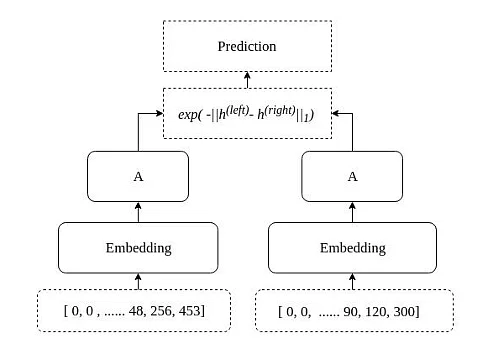

In [235]:
# import necessary library
from keras.layers import Input, LSTM, Embedding, Dropout, Dense, Lambda
from keras.models import Model

In [237]:
# define the input layers for the two language data
input_en = Input(shape=(max_length,))
input_my = Input(shape=(max_length,))

In [260]:
# Define the embedding layer, with a vocabulary size 
# and embedding dimension (from word2vec) and max_length defined earlier
embedding_layer = Embedding(vocab_size, 
                            embedding_dim, 
                            input_length=max_length, trainable=True)

# Apply the embedding layer to the input layers
embedded_en = embedding_layer(input_en)
embedded_my = embedding_layer(input_my)

In [261]:
# Define the LSTM cells for the Siamese NN

lstm_layer = LSTM(256)

In [240]:
# Apply the LSTM cells to the embedded input layers
encoded_en = lstm_layer(embedded_en)
encoded_my = lstm_layer(embedded_my)

# Add a dropout layer to prevent overfitting
dropout = Dropout(0.2)
dropout_en = dropout(encoded_en)
dropout_my = dropout(encoded_my)

In [241]:
# Define the merged function
# To a numerical representation of the 
# difference between the two encoded sequences
merged = Lambda(function=lambda x: abs(x[0] - x[1]), output_shape=lambda x: x[0])([encoded_en, encoded_my])

# Add a Dense Layer and dropout after each dense layer
merged = Dense(32, activation='relu')(merged)
merged = Dropout(0.2)(merged)

In [242]:
# Define the output layer with sigmoid function as our output is binary
output = Dense(1, activation='sigmoid')(merged)

In [243]:
# Create the model
model_nn = Model(inputs=[input_en, input_my], outputs=output)
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [244]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# For model to stop training without having to run through all epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpoint_path = "/kaggle/working/nn_model_{epoch:02d}--{val_loss:.2f}.h5"

# Create a ModelCheckpoint object
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False, save_freq='epoch')

In [245]:
import numpy as np

In [266]:
# Train the model
model_nn.fit([train_en_sequences, train_my_sequences], 
             np.array(train_cl).astype(int), 
             epochs=20, batch_size=512, 
             validation_data=([dev_en_sequences, dev_my_sequences],np.array(dev_cl).astype(int)), 
             callbacks=[early_stopping,checkpoint])

Epoch 1/20
293/293 [==============================] - 160s 548ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 2.5697 - val_accuracy: 0.7234
Epoch 2/20
293/293 [==============================] - 161s 548ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 2.6734 - val_accuracy: 0.7106
Epoch 3/20
293/293 [==============================] - 160s 548ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 2.3760 - val_accuracy: 0.7306
Epoch 4/20
293/293 [==============================] - 160s 547ms/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 2.2169 - val_accuracy: 0.7344
Epoch 5/20
293/293 [==============================] - 160s 548ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 2.5708 - val_accuracy: 0.7066
Epoch 6/20
293/293 [==============================] - 161s 548ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 2.1696 - val_accuracy: 0.7410
Epoch 7/20
293/293 [==============================] - 160s 547ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 2.2649 -

# Model Evaluation

**Make Predictions using the model trained with testing data.**

In [267]:
# Make predictions using test sequences.
predictions = model_nn.predict([test_en_sequences, test_my_sequences])
predictions = np.round(predictions)

In [255]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [268]:
# Create the confusion matrix
confusion_mat = confusion_matrix(np.array(test_cl).astype(int), predictions)
print(confusion_mat)
print(classification_report(np.array(test_cl).astype(int), predictions))

[[18734  1266]
 [ 2466 17534]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     20000
           1       0.93      0.88      0.90     20000

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000



In [269]:
# Output the accuracy score
acc = accuracy_score(np.array(test_cl).astype(int), predictions)
print("Accuracy: ", acc)

Accuracy:  0.9067
